#Project 2
James Artuso

RUID: 202008796

12/1/22


In [1]:
#This is installing all the relevant packages
!pip3 install gym[classic_control]
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 1.3 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 5 not upgraded.
Need to get 994 kB of archives.
After this operation, 2,982 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Ign:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 

In [2]:
#This is setting up the relevant packages
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import time

if gym.__version__ < '0.26':
    env = gym.make('CartPole-v0', new_step_api=True, render_mode='single_rgb_array').unwrapped
else:
    env = gym.make('CartPole-v0', render_mode='rgb_array').unwrapped

#set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [3]:
# This is creating the ReplayMemory class. This is to save the transistion that 
#choosen. A transition includes the current state, current action taken, the next state
# and the current reward. It is important to save these values for the implementation
# of Q-Learning.
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
# This is sets up the DQN network. This is the actual network that will be trained.
# This network takes the state in and outputs the expected Q value. The 
# action that would lead to the max Q value is choosen.
# This network is trained as the environment is simulated over and over.
# The input state is the pixels in a difference of two consecutive screens.

class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        #This DQN has three convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(64)

        # This network has one linear layer that maps to the number of outputs
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 64
        self.head = nn.Linear(linear_input_size, outputs)

    # The nonlinear function used is relu.
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [5]:
#These are helper methods
resize = T.Compose([T.ToPILImage(),
                    T.Resize(64, interpolation=Image.BILINEAR),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)

def get_screen():
    screen = env.render().transpose((2, 0, 1))

    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)

    screen = screen[:, :, slice_range]

    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)

    return resize(screen).unsqueeze(0)

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


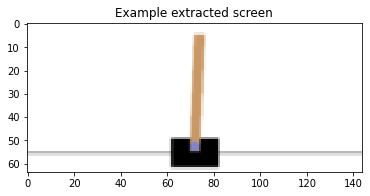

In [6]:
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [31]:
# These are parameters that can be tuned to change the DQN performance and
# training speed
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 2000
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=0.0001, weight_decay=0.01, amsgrad=True)
memory = ReplayMemory(100000)
steps_done = 0


# This method selects the action that will be taken. If number of steps is greater than
# the eps_threshold, then it will get the action from the policy network. If sample
# is less than eps_threshold, it will pick an action at random. 
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []

# This is a helper method to plot the duration of each training episode
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.show()

In [30]:
# This is the method that optimizes the neural network that approximates the 
# Q function. This optimization is done using the reward from the selected action.
# A policy network and a target network are used here. The target_net
# is meant be used for finding Y = r_t + ymax_aQ(s_t+1, a)
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net. These values will be compared
    # to the expected state value from the target_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final. This is the network that finds
    # Y.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model. This updates policy_net to better approximate
    # the Q function.
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


0: maxDuration: 13; currDuration: 12
1: maxDuration: 23; currDuration: 22
2: maxDuration: 23; currDuration: 11
3: maxDuration: 23; currDuration: 15
4: maxDuration: 23; currDuration: 11
5: maxDuration: 23; currDuration: 13
6: maxDuration: 23; currDuration: 15
7: maxDuration: 31; currDuration: 30
8: maxDuration: 31; currDuration: 13
9: maxDuration: 31; currDuration: 19
10: maxDuration: 33; currDuration: 32
11: maxDuration: 33; currDuration: 15
12: maxDuration: 33; currDuration: 10
13: maxDuration: 33; currDuration: 15
14: maxDuration: 33; currDuration: 14
15: maxDuration: 33; currDuration: 12
16: maxDuration: 33; currDuration: 11
17: maxDuration: 33; currDuration: 13
18: maxDuration: 33; currDuration: 14
19: maxDuration: 54; currDuration: 53
20: maxDuration: 54; currDuration: 23
21: maxDuration: 54; currDuration: 19
22: maxDuration: 54; currDuration: 15
23: maxDuration: 54; currDuration: 18
24: maxDuration: 54; currDuration: 41
25: maxDuration: 54; currDuration: 13
26: maxDuration: 54; c

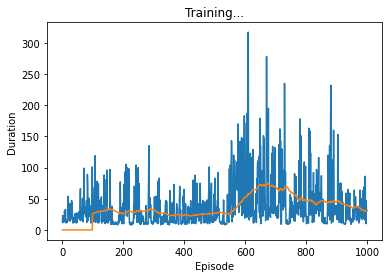

In [32]:
# The num_episodes tells the program how many times to simulate the environment.
num_episodes = 1000
maxDuration = 0
# I added a way to save the best network so far
# While the policy_net is updated each step so there is no exact "best network", 
# this is just a way to get a network that is potentially
# better than the network at the end of training.
best_net = DQN(screen_height, screen_width, n_actions).to(device)


i = 1
since = time.time()
episode_durations = []

# This is the loop to run for n many episodes. An episode is one 
# execution of the environment. This means it runs until the environment 
# terminates. 
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    # This is the input state that is used for the network. 
    # The input is the difference of pixels between the current and last
    # screen. Another potential choice for state is the observation space 
    # however, the tutorial choose to use the image.
    state = current_screen - last_screen

    # This loops over the steps.
    for t in count():
        # Select and perform an action. The select_action method sends the 
        # current state to the DQN and the DQN returns action it thinks
        # will return the maximum reward
        action = select_action(state)

        # Here, the environment transitions from the current state to the next state.
        # The step function returns the new observation space, the reward of the action taken
        # and whether the simulation should be terminated or not. 
        observation, reward, done, _, _ = env.step(action.item())

        # I added these lines to compare different reward functions. The default
        # reward function is discrete in that it only returns 1 or 0. This new reward
        # function is continous. As the cart moves away from the center and
        # the pole angle increases, the reward decreases. It is always less than
        # or equal to zero at terminating conditions.
        # Compared to the default reward function, the training for this function
        # is a little slower, however the peak duration is a little higher but not
        # by an amount to justify fully replacing the original reward function.
        #cartPos = observation[0]
        #poleAngle = observation[2]
        #reward = (1-((cartPos ** 2)/5.76) - ((poleAngle ** 2)/.04389))



        reward = torch.tensor([reward], device=device)

        

        # Observe new state. This calculates s_t+1.
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory. This is so the network can 
        # train from it later using Q-learning. 
        memory.push(state, action, next_state, reward)

        # This sets s_t to s_t+1 so the loop can execute again.
        state = next_state

        # This is a line I added. This saves the the current max duration
        # network into best_net.
        if done:
            if(maxDuration < (t+1)):
              maxDuration = (t+1)
              best_net.load_state_dict(policy_net.state_dict())
        # Perform one step of the optimization (on the policy network)
        optimize_model()
        # This is for graphing the training performance later.
        if done:
            episode_durations.append(t + 1)
            break

        # Update the target network, copying all weights and biases in DQN.
        # This is to keep target_net more recent.
        if t % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

    #This is code I added to see the performance more clearly
    if((i_episode+1) % (num_episodes/10) == 0):
      print(f'Tenth Done: ({i}/10)')
      timeElapsed = time.time() - since
      print(f'Tenth {i} time {timeElapsed // 60:.0f}m {timeElapsed % 60:.0f}s')
      i = i + 1
      # This is the save the policy so I dont loose work incase 
      # something happens
      torch.save(policy_net.state_dict(), 'currentPolicy')
    print(f'{i_episode}: maxDuration: {maxDuration}; currDuration: {t}')


print('Complete')
plot_durations()

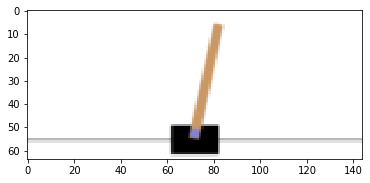

In [10]:
# The rest of the notebook is not part of the RL algorithm. It is 
# more so for testing and gathering performance metrics. 
env.render()
env.close()
plt.ioff()
plt.show()
plt.imshow(get_screen().cpu().squeeze(0).permute(1,2,0).numpy(), interpolation = 'none')

In [11]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
before_training = "before_training.mp4"
video = VideoRecorder(env, before_training)
duration = 0
env.reset()
for i in range(200):
  env.render()
  video.capture_frame()
  observation, reward, done, info, _ = env.step(env.action_space.sample())


video.close()
env.close()
print(duration)

/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/envs/classic_control/cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


0


In [12]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:

  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [13]:
from IPython.display import HTML
html = render_mp4(before_training)
HTML(html)

In [14]:
after_training = "after_training.mp4"
after_video = VideoRecorder(env, after_training)


env.reset(seed = 10)

last_screen = get_screen()
current_screen = get_screen()
state = current_screen - last_screen


done = False

#Loading policy networks

#policy_net.load_state_dict(torch.load('policy800', map_location = torch.device(device))) #For imported policies
policy_net.load_state_dict(best_net.state_dict()) #For best saved policy
#policy_net.load_state_dict(torch.load('currentPolicy', map_location = torch.device(device))) #Reload final policy after training

# Need to use the DQN and render each frame
for i in range(200):
  env.render()
  after_video.capture_frame()

   # Select and perform an action
  action = select_action(state)
  _, reward, done, _, _ = env.step(action.item())
  reward = torch.tensor([reward], device=device)

  # Observe new state
  last_screen = current_screen
  current_screen = get_screen()
  next_state = current_screen - last_screen

  # Move to the next state
  state = next_state


after_video.close()
env.close()

#View video
html = render_mp4(after_training)
HTML(html)

/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/envs/classic_control/cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


In [15]:
torch.save(policy_net.state_dict(), 'currentPolicy') #For saving different networks

In [16]:
# This method gets the average duration of a DQN. 1000 trials are used
# Each trial is randomly generated.
def getAvgDuration(testNet):
  avgDuration = 0
  numTrials = 1000
  policy_net.load_state_dict(testNet.state_dict())
  for i in range(numTrials):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    done = False
    duration = 0
    done = False
    while not done:
      action = select_action(state)
      _, _, done, _, _ = env.step(action.item())


      last_screen = current_screen
      current_screen = get_screen()

      state = current_screen - last_screen
      

      duration = duration + 1

    avgDuration += duration
    
  avgDuration = avgDuration/numTrials
  return avgDuration

In [17]:
# This gets the average duration when choosing actions randomly
def getAvgRandomDuration():
  avgDuration = 0
  numTrials = 1000
  for i in range(numTrials):
    env.reset()
    duration = 0
    done = False
    while not done:
      observation, reward, done, info, _ = env.step(env.action_space.sample())
      duration = duration + 1
    avgDuration += duration
  avgDuration = avgDuration/numTrials
  return avgDuration

In [20]:
# policy200 is the NN trained for 200 episodes
# policy800 is the NN trained for 800 episodes
randomPolicy = getAvgRandomDuration()
policy_net = DQN(screen_height, screen_width, n_actions).to(device)
shortLength = getAvgDuration(policy_net)
policy_net.load_state_dict(torch.load('/content/policy200', map_location = torch.device(device)))
midLength = getAvgDuration(policy_net)
policy_net.load_state_dict(torch.load('/content/policy800', map_location = torch.device(device)))
longLength = getAvgDuration(policy_net)
print(randomPolicy)
print(shortLength)
print(midLength)
print(longLength)

21.961
36.534
49.945
115.27


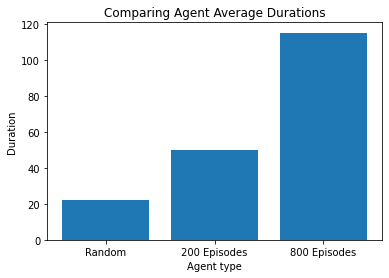

In [21]:
agentName = ('Random', '200 Episodes', '800 Episodes')
fig, ax = plt.subplots()
hbars = ax.bar(agentName, [randomPolicy, midLength, longLength])
ax.set_xlabel('Agent type')
ax.set_ylabel('Duration')
plt.title('Comparing Agent Average Durations')
plt.show()

In [22]:
def countReward(testNet):
  policy_net.load_state_dict(testNet.state_dict())
  rewards = [1]
  duration = 0
  done = False
  env.reset(seed = 1)
  last_screen = get_screen()
  current_screen = get_screen()
  state = current_screen - last_screen
  while not done:
    action = select_action(state)
    observation, _, done, _, _ = env.step(action.item())

    cartPos = observation[0]
    poleAngle = observation[2]
    reward = (1-((cartPos ** 2)/5.76) - ((poleAngle ** 2)/.04389))

    rewards.append(reward)


    last_screen = current_screen
    current_screen = get_screen()

    state = current_screen - last_screen
    duration = duration + 1
  return rewards

In [23]:
def countRewardRandom():
  rewards = [1]
  duration = 0
  done = False
  env.reset(seed = 1)
  while not done:
    # Select and perform an action
    observation, reward, done, info, _ = env.step(env.action_space.sample())
    # The newer reward function is choosen here because it provides more 
    # interesting and insightful results on the performance of the networks.
    cartPos = observation[0]
    poleAngle = observation[2]
    reward = (1-((cartPos ** 2)/5.76) - ((poleAngle ** 2)/.04389))
    rewards.append(reward)
    duration = duration + 1
  return rewards

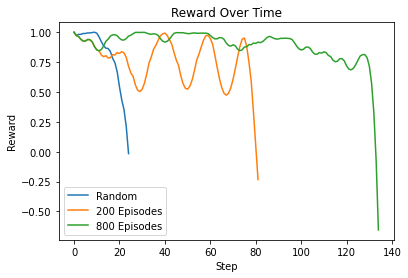

In [24]:
randomRewards = countRewardRandom()
policy_net.load_state_dict(torch.load('/content/policy200', map_location = torch.device(device)))
midRewards = countReward(policy_net)
policy_net.load_state_dict(torch.load('/content/policy800', map_location = torch.device(device)))
longRewards = countReward(policy_net)

fig, ax = plt.subplots()
tRandom = range(len(randomRewards))
tMid = range(len(midRewards))
tLong = range(len(longRewards))
ax.plot(tRandom, randomRewards, label='Random')
ax.plot(tMid, midRewards, label = '200 Episodes')
ax.plot(tLong, longRewards, label = '800 Episodes')
legend = ax.legend(loc='lower left')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Reward Over Time')
plt.show()